In [11]:
#coding:utf-8
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from pylab import*
from scipy.ndimage import convolve
from scipy.ndimage import label
from google.colab.patches import cv2_imshow
import heapq
import matplotlib.font_manager as fm
from skimage.restoration import denoise_tv_chambolle
from skimage.segmentation import active_contour, watershed
from skimage import io, img_as_float
from scipy.ndimage import distance_transform_edt
from skimage.filters import sobel
import numpy as np
from scipy.signal import convolve2d



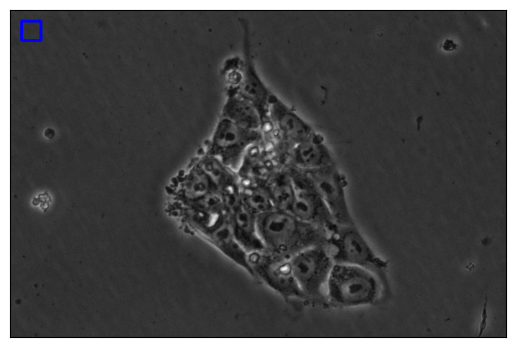

<ipython-input-12-80b255e0deb9>:23: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  diffusion = sum(c * g for c, g in zip(conduction_coeffs, gradients))


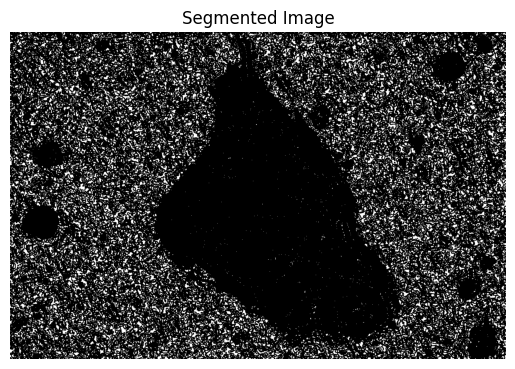

In [12]:
def compute_gradients(image):
    """Computes image gradients using finite difference kernels."""
    kernels = [
        np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]], np.float64),  # North
        np.array([[0, 0, 0], [0, -1, 0], [0, 1, 0]], np.float64),  # South
        np.array([[0, 0, 0], [0, -1, 1], [0, 0, 0]], np.float64),  # East
        np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]], np.float64)   # West
    ]
    return [convolve2d(image, k, mode='same', boundary='symm') for k in kernels]


def perona_malik_conduction(gradients, kappa, method='quadratic'):
    """Computes the conduction coefficient for each gradient direction."""
    if method == 'quadratic':
        return [np.exp(-(g / kappa) ** 2) for g in gradients]
    elif method == 'exponential':
        return [1 / (1 + (g / kappa) ** 2) for g in gradients]
    else:
        raise ValueError("Invalid conduction method. Use 'quadratic' or 'exponential'.")

def update_image(image, gradients, conduction_coeffs, delta_t):
    """Updates the image based on computed diffusion terms."""
    diffusion = sum(c * g for c, g in zip(conduction_coeffs, gradients))
    return image + delta_t * diffusion

def perona_malik_diffusion(image, iterations, delta_t, kappa, method='quadratic'):
    """Applies Perona-Malik anisotropic diffusion to an image."""
    image = image.astype(np.float64)
    for _ in range(iterations):
        gradients = compute_gradients(image)
        conduction_coeffs = perona_malik_conduction(gradients, kappa, method)
        image = update_image(image, gradients, conduction_coeffs, delta_t)
    return np.clip(image, 0, 255).astype(np.uint8)


def apply_perona_malik(image_path, iterations=20, delta_t=0.1, kappa=20, method='quadratic'):
    """Loads an image, applies Perona-Malik diffusion, and returns the processed image."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Error: Could not read {image_path}. Check if the file exists.")
        return None

    processed = perona_malik_diffusion(image, iterations, delta_t, kappa, method)
    return image, processed  # Return both original and processed images


# Try importing cv2_imshow for Google Colab; otherwise, use cv2.imshow for a normal environment
try:
    from google.colab.patches import cv2_imshow  # For Colab
except ImportError:
    cv2_imshow = cv2.imshow  # For regular Python environments

# Define constants
INF = np.finfo(np.float32).max  # A large value representing infinite distance
ALIVE, TRIAL, FAR = -1, 0, 1  # States for pixels in the distance transform

def initialize_gwdt(image):
    """Initialize state and distance maps based on image intensity."""
    rows, cols = image.shape
    mean_val = np.mean(image)  # Compute mean intensity of the image

    # Initialize state map (default FAR) and distance map (default INF)
    state = np.full((rows, cols), FAR, dtype=np.int8)
    distance_map = np.full((rows, cols), INF, dtype=np.float32)

    # Identify foreground pixels (below mean intensity) as ALIVE and set initial distances
    mask = image < mean_val
    distance_map[mask] = image[mask].astype(float)
    state[mask] = ALIVE

    return state, distance_map

def compute_gwdt(image):
    """Compute the Grey Weighted Distance Transform (GWDT)."""
    rows, cols = image.shape
    state, distance_map = initialize_gwdt(image)  # Initialize state and distance maps
    pq = []  # Priority queue for processing pixels

    # Identify border pixels adjacent to ALIVE pixels and initialize them as TRIAL
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if state[i, j] == FAR:
                if np.any(state[i-1:i+2, j-1:j+2] == ALIVE):  # Check if any neighbor is ALIVE
                    state[i, j] = TRIAL
                    distance_map[i, j] = float(image[i, j])  # Set initial distance
                    heapq.heappush(pq, (distance_map[i, j], i, j))  # Add to priority queue

    # Process pixels in priority queue
    while pq:
        current_dist, i, j = heapq.heappop(pq)  # Extract pixel with smallest distance

        # Iterate over 8-connected neighborhood
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            ni, nj = i + di, j + dj
            if 0 <= ni < rows and 0 <= nj < cols:  # Ensure the pixel is within bounds
                gs = current_dist + image[ni, nj] * np.hypot(di, dj)  # Compute weighted distance

                if distance_map[ni, nj] > gs:  # Update distance if a shorter path is found
                    distance_map[ni, nj] = gs
                    state[ni, nj] = TRIAL
                    heapq.heappush(pq, (gs, ni, nj))  # Add updated pixel to priority queue

    # Normalize distance values for visualization
    distance_map[distance_map == INF] = 0  # Replace INF values with 0
    max_val = np.max(distance_map)

    if max_val > 0:
        distance_map = (distance_map / (max_val + 1)) * 255  # Normalize to [0, 255]
    else:
        distance_map.fill(0)  # Handle case where all distances are zero

    return distance_map.astype(np.uint8)  # Convert to uint8 for image display


# Load and preprocess the image
Image = cv2.imread('genimage.tif', 1)  # Read input image
image = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
img = np.array(image, dtype=np.float64)  # Convert to float64

# Initialize Level Set Function (LSF)
IniLSF = np.ones((img.shape[0], img.shape[1]), img.dtype)
IniLSF[30:80, 30:80] = -1
IniLSF = -IniLSF

# Draw initial contour
Image = cv2.cvtColor(Image, cv2.COLOR_BGR2RGB)
plt.figure(1), plt.imshow(Image), plt.xticks([]), plt.yticks([])
plt.contour(IniLSF, [0], colors='b', linewidths=2)
plt.draw(), plt.show(block=False)

# Function for mathematical operations
def mat_math(input_mat, operation):
    output = input_mat.copy()
    for i in range(input_mat.shape[0]):
        for j in range(input_mat.shape[1]):
            if operation == "atan":
                output[i, j] = math.atan(input_mat[i, j])
            elif operation == "sqrt":
                output[i, j] = math.sqrt(input_mat[i, j])
    return output

# Chan-Vese Function
def CV(LSF, img, mu, nu, epsilon, step):
    Drc = (epsilon / math.pi) / (epsilon * epsilon + LSF * LSF)
    Hea = 0.5 * (1 + (2 / math.pi) * mat_math(LSF / epsilon, "atan"))
    Iy, Ix = np.gradient(LSF)
    s = mat_math(Ix * Ix + Iy * Iy, "sqrt")
    Nx = Ix / (s + 1e-6)
    Ny = Iy / (s + 1e-6)
    Mxx, Nxx = np.gradient(Nx)
    Nyy, Myy = np.gradient(Ny)
    cur = Nxx + Nyy
    Length = nu * Drc * cur

    Lap = cv2.Laplacian(LSF, cv2.CV_64F)  # Fixing Laplacian data type issue
    Penalty = mu * (Lap - cur)

    s1 = Hea * img
    s2 = (1 - Hea) * img
    s3 = 1 - Hea
    C1 = s1.sum() / Hea.sum()
    C2 = s2.sum() / s3.sum()
    CVterm = Drc * (-1 * (img - C1) * (img - C1) + 1 * (img - C2) * (img - C2))

    LSF = LSF + step * (Length + Penalty + CVterm)
    return LSF


# 2. Compute Grey-Weighted Distance Transform (GWDT)
def grey_weighted_distance(img, markers):
    inv_img = np.max(img) - img  # Invert for intensity-based cost
    gwdt = compute_gwdt(inv_img)
    return gwdt * (markers > 0)  # Apply only to marker regions


# 4. Unified Stopping Criteria
def stopping_criteria(G, D, C, w1=0.5, w2=0.3, w3=0.2, threshold=0.5):
    S = w1 * G + w2 * D + w3 * C
    return S < threshold  # Stop if combined measure is below threshold

# 5. Full Segmentation Pipeline
def segment_image(image_path, marker_path):
    """Performs image segmentation using Perona-Malik filtering, GWDT, and stopping criteria."""

    # Step 1: Load and preprocess image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    markers = cv2.imread(marker_path, cv2.IMREAD_GRAYSCALE) > 128  # Convert to binary markers

    if image is None or markers is None:
        print("Error: Unable to load image or marker.")
        return None

    # Step 2: Apply Perona-Malik diffusion
    #smoothed = perona_malik_diffusion(image, iterations=20, delta_t=0.1, kappa=20, method='quadratic')
    smoothed = perona_malik_diffusion(image, iterations=20, delta_t=0.1, kappa=20, method='quadratic')


    # Step 3: Compute Grey-Weighted Distance Transform (GWDT)
    gwdt = grey_weighted_distance(smoothed, markers)

    # Step 4: Compute Gradient Magnitude
    gradient_x = cv2.Sobel(smoothed, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(smoothed, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # Step 5: Compute Confidence Map (simple binary thresholding)
    mean_intensity = np.mean(smoothed)
    confidence_map = np.where(smoothed > mean_intensity, 1, 0)

    # Step 6: Apply Stopping Criteria
    segmentation_mask = stopping_criteria(gradient_magnitude, gwdt, confidence_map, w1=0.5, w2=0.3, w3=0.2, threshold=0.5)

    # Normalize and return segmentation result
    segmented_image = (segmentation_mask * 255).astype(np.uint8)
    return segmented_image


# Example usage:
segmented_result = segment_image("genimage.tif", "markerimage.tif")
if segmented_result is not None:
    plt.imshow(segmented_result, cmap='gray')
    plt.title("Segmented Image")
    plt.axis("off")
    plt.show()
